In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm


top_level=f'{os.getcwd()}/../../../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras

%run ../../ASIC_V4/supportFunctions.ipynb

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False,
    dev         = '/dev/datadev_0',
    asicVersion = 4
)
root.start()

Simulation mode : False
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 2 days, 11:21:43
GitHash      = 0x563a68027652195474e6a610098a11775111615a
XilinxDnaId  = 0x4002000101604ee71c61a3c5
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.2
BuildServer  = rdsrv408 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 02 Nov 2023 02:16:58 PM PDT
Builder      = ddoering
###################################################


# Calculate diff from Normal dist
The function does the following:
- fits a normal distribution around the data
- calculates the difference between data and normal distribution for each bin 
- returns the integral of the difference

In [4]:
def diffNormal(data, bins):
    """
    Fit a normal distribution to the data array and compare observed vs expected frequencies in each bin.

    Parameters:
    - data: 1D array or list
        The data array.
    - num_bins: int, optional (default=10)
        Number of bins for sorting the data.

    Returns:
    - difference: 1D array
        Difference between observed and expected counts in each bin.
    - mu: 
        From normal fitting
    """
    
    # Sort the data into bins
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Calculate expected frequencies based on the fitted normal distribution
    expected_counts = len(data) * np.diff(norm.cdf(bin_edges, loc=mu, scale=std))

    # Compute the difference between observed and expected frequencies
    difference = np.sum(abs((counts - expected_counts)))

    return difference, mu

This function is for plotting/debugging

In [5]:
def fit_and_compare(data, bins):
    """
    Fit a normal distribution to the data array and compare observed vs expected frequencies in each bin.

    Parameters:
    - data: 1D array or list
        The data array.
    - num_bins: int, optional (default=10)
        Number of bins for sorting the data.

    Returns:
    - bin_centers: 1D array
        Centers of the bins.
    - observed_counts: 1D array
        Observed counts in each bin.
    - expected_counts: 1D array
        Expected counts based on the fitted normal distribution.
    - difference: 1D array
        Difference between observed and expected counts in each bin.
    """
    # Sort the data into bins
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Calculate expected frequencies based on the fitted normal distribution
    expected_counts = len(data) * np.diff(norm.cdf(bin_edges, loc=mu, scale=std))

    # Compute the difference between observed and expected frequencies
    difference = (counts - expected_counts)

    # Plot the histogram and the fitted normal distribution
    plt.hist(data, bins=bins, density=False, alpha=0.6, color='g', label='Histogram')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(bin_centers[:], difference, color='red', label='Difference')
    plt.plot(x, p * len(data) * np.diff(bin_edges)[0], 'k', linewidth=2, label='Fitted Normal Distribution')
    plt.legend()
    plt.title('Fit Results')
    plt.show()


# Baseline TEST all - 320MHz refGenB,RefGenC modified

In [6]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

Camera  ePixHr10kTBatcher  selected.


In [7]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
initSequence = 5
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_RegisterControl_R0Width12us_AcqWidth24us_320MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_2.yml
Command executed :  <class 'pyrogue._Command.BaseC

In [8]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(10)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [9]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)



Locked lanes: 3f000


In [10]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

# ------------------------------------ ADC
# Disable external DAC
ASIC.mTest.set(False)

# ADC settings
ASIC.RefGenB.set(1) #2 bits
ASIC.RefGenC.set(2) #2 bits
ASIC.S2D_1_b.set(0) #3 bits
ASIC.shvc_DAC.set(30) #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(False)

# ------------------------------------ Pixel
# Set references 
Preamp     = 3 #4
Vld1_b     = 1 #1
Pixel_CB   = 4 #4
Filter_DAC = 24 #38
VRef_DAC   = 40 #53
CompTH_DAC = 28

# Write data
setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
ASIC.CompTH_DAC.set(CompTH_DAC)

ASIC.CompEn.set(2)
ASIC.CompEnOn.set(True) 

# Set High Gain ----------------------------------------------------------
cfgHG = True

if cfgHG==True:
    gainCfg = 'HG'
else:
    gainCfg = 'MG'

ASIC.trbit.set(cfgHG) # high/medium gain
print (f'Check trbit (0: medium gain, 1: high gain): %d' % ASIC.trbit.get())


# ------------------------------------ Pulser for Charge injection
ASIC.PulserR.set(True)
ASIC.PulserR.set(False)
ASIC.MonostPulser.set(7)

# Configure Pulser Ch. Injection
ASIC.test.set(False)
ASIC.atest.set(False)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/lorenzor/10kthr_data/temp.dat')

Preamp 3
Vld1_b 1
Pixel_CB 4
Filter_DAC 24
VRef_DAC 40
Check trbit (0: medium gain, 1: high gain): 1


# Pixel baseline

In [11]:
# Take data
dataOpt = run_asic_test(numFrames = 2000, initialDelay = 0)[:,:,0:192]

/u1/lorenzor/10kthr_data/temp.dat
Aquisition Counter 1199284
DAQ Counter 1174154
Number of frames received: 0
Delta Aquisition Counter: 2001
Number of frames received: 2001
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


In [12]:
# Downsampling
dataOpt14b = np.bitwise_and(dataOpt, 0xFFFF)
dataOpt13b = np.bitwise_and(dataOpt, 0xFFFE)
dataOpt12b = np.bitwise_and(dataOpt, 0xFFFC)
dataOpt11b = np.bitwise_and(dataOpt, 0xFFF8)
dataOpt10b = np.bitwise_and(dataOpt, 0xFFF0)

In [13]:
# Dark data
data14b = np.median(dataOpt14b, axis=0)
data13b = np.median(dataOpt13b, axis=0)
data12b = np.median(dataOpt12b, axis=0)
data11b = np.median(dataOpt11b, axis=0)
data10b = np.median(dataOpt10b, axis=0)

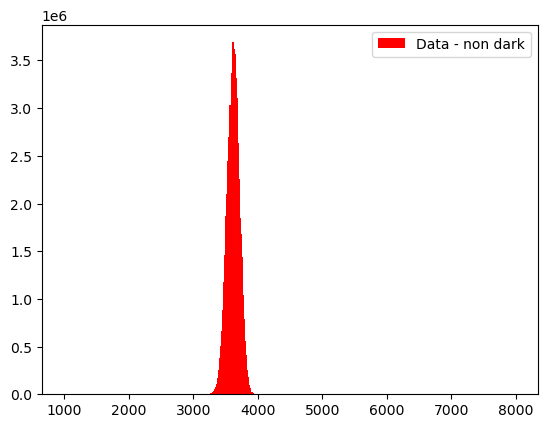

In [14]:
binwidth = 16;
bins     = np.arange(1000, 8000, binwidth);
plt.hist(dataOpt14b.flatten(), bins=bins, color='red',  label = 'Data - non dark');
plt.legend()

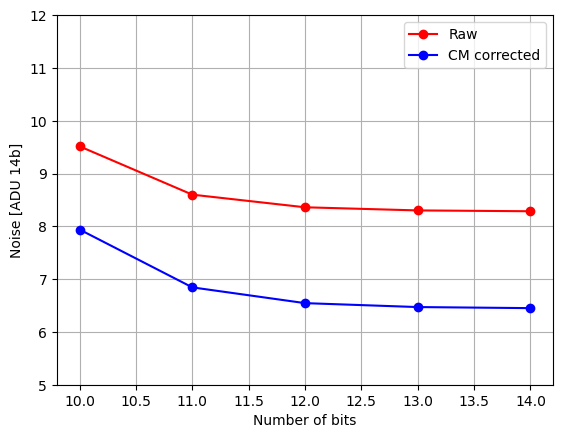

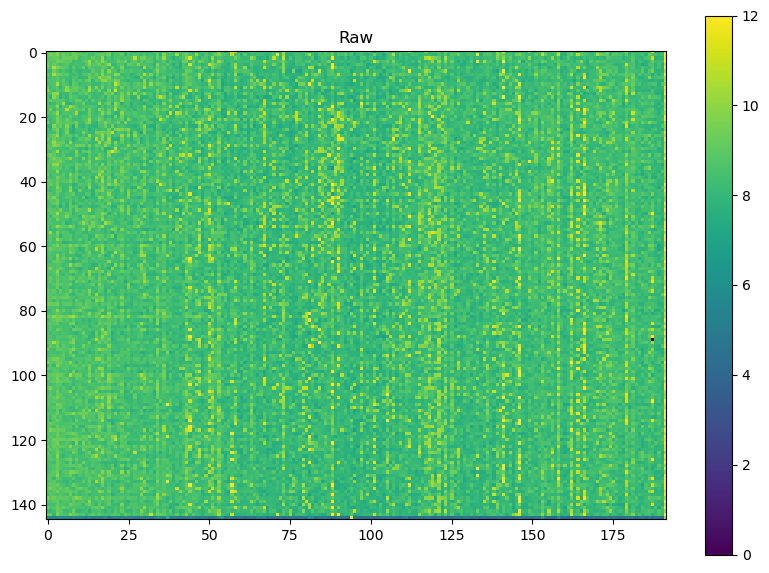

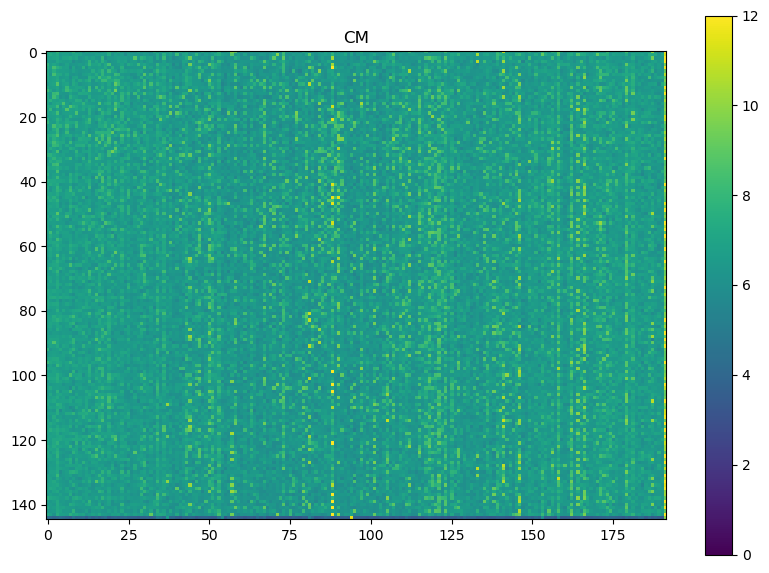

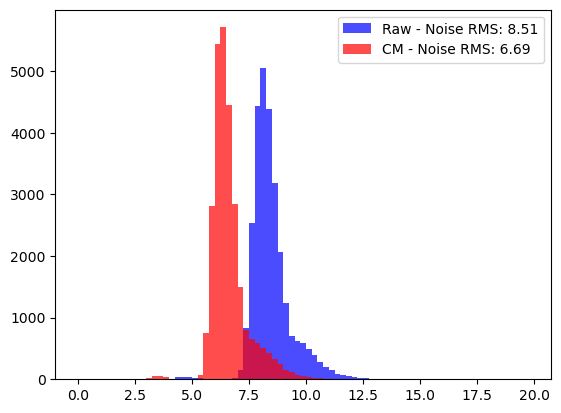

In [18]:
# Noise

dataCM14b = dataOpt14b - data14b - np.mean(dataOpt14b, axis=(1,2), keepdims=True)
dataCM13b = dataOpt13b - data13b - np.mean(dataOpt13b, axis=(1,2), keepdims=True)
dataCM12b = dataOpt12b - data12b - np.mean(dataOpt12b, axis=(1,2), keepdims=True)
dataCM11b = dataOpt11b - data11b - np.mean(dataOpt11b, axis=(1,2), keepdims=True)
dataCM10b = dataOpt10b - data10b - np.mean(dataOpt10b, axis=(1,2), keepdims=True)

dataCM14b -= np.mean(dataCM14b, axis=(1), keepdims=True)
dataCM13b -= np.mean(dataCM13b, axis=(1), keepdims=True)
dataCM12b -= np.mean(dataCM12b, axis=(1), keepdims=True)
dataCM11b -= np.mean(dataCM11b, axis=(1), keepdims=True)
dataCM10b -= np.mean(dataCM10b, axis=(1), keepdims=True)

dataCM14b -= np.mean(dataCM14b, axis=(2), keepdims=True)
dataCM13b -= np.mean(dataCM13b, axis=(2), keepdims=True)
dataCM12b -= np.mean(dataCM12b, axis=(2), keepdims=True)
dataCM11b -= np.mean(dataCM11b, axis=(2), keepdims=True)
dataCM10b -= np.mean(dataCM10b, axis=(2), keepdims=True)


noise14b = np.std(dataOpt14b, axis=0)
noise13b = np.std(dataOpt13b, axis=0)
noise12b = np.std(dataOpt12b, axis=0)
noise11b = np.std(dataOpt11b, axis=0)
noise10b = np.std(dataOpt10b, axis=0)


noise14bCM = np.std(dataCM14b, axis=0)
noise13bCM = np.std(dataCM13b, axis=0)
noise12bCM = np.std(dataCM12b, axis=0)
noise11bCM = np.std(dataCM11b, axis=0)
noise10bCM = np.std(dataCM10b, axis=0)


noiseVSbits = [np.median(noise10b), np.median(noise11b), np.median(noise12b),np.median(noise13b),np.median(noise14b)]     
noiseVSbitsCM = [np.median(noise10bCM), np.median(noise11bCM), np.median(noise12bCM),np.median(noise13bCM),np.median(noise14bCM)]            

bitres = [10,11,12,13,14]

plt.plot(bitres, noiseVSbits, 'o-', label='Raw', color='r');
plt.plot(bitres, noiseVSbitsCM, 'o-', label='CM corrected', color='b');
plt.xlabel('Number of bits')
plt.ylabel('Noise [ADU 14b]')

plt.ylim([5,12])
plt.grid()
plt.legend()
plt.show()


plt.figure(figsize = (10,7))

plt.imshow(noise14b, vmin=0, vmax=12)
# plt.imshow(data14b)

plt.colorbar()
plt.title('Raw')
plt.show()

plt.figure(figsize = (10,7))
plt.imshow(noise12bCM, vmin=0, vmax=12)
plt.colorbar()
plt.title('CM')
plt.show()

noisebins     = np.arange(0, 20, 0.25);
rmsCM = np.sqrt(np.mean(noise14bCM.flatten()**2))
rmsRaw = np.sqrt(np.mean(noise14b.flatten()**2))

plt.hist(noise14b.flatten(), bins=noisebins, color='blue',  label = 'Raw - Noise RMS: {:.2f}'.format(rmsRaw), alpha=0.7);
plt.hist(noise14bCM.flatten(), bins=noisebins, color='red',  label = 'CM - Noise RMS: {:.2f}'.format(rmsCM), alpha=0.7);
plt.legend()
plt.show()


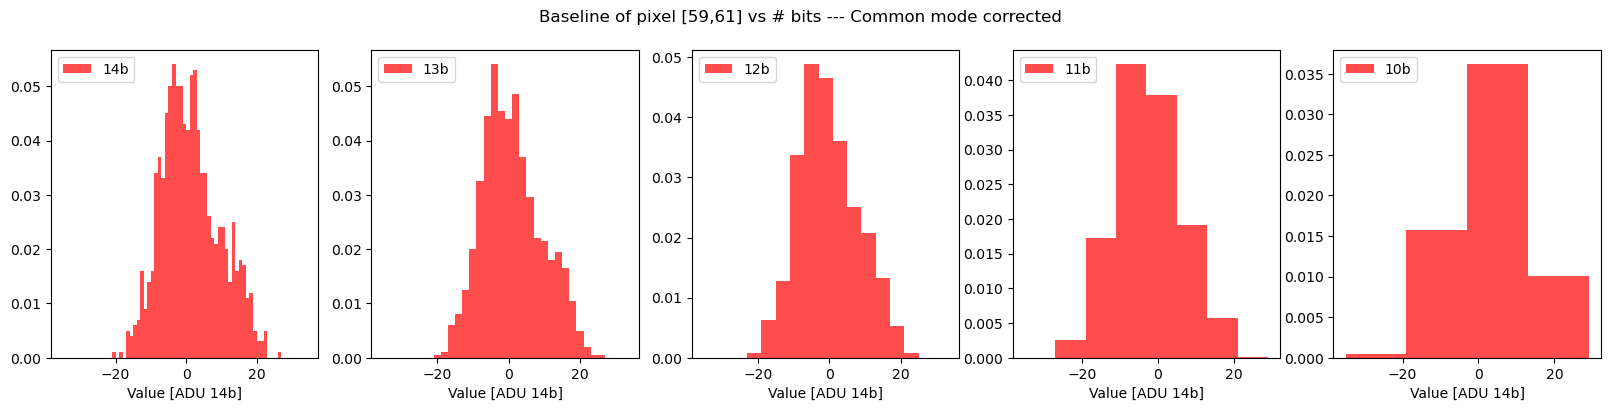

In [24]:
pixCol = 61
pixRow = 59

minADU = 3510
maxADU = 3580

x = np.linspace(minADU, maxADU, maxADU-minADU)

bins14b     = np.arange(minADU, maxADU, 1);
bins13b     = np.arange(minADU, maxADU, 2);
bins12b     = np.arange(minADU, maxADU, 4);
bins11b     = np.arange(minADU, maxADU, 8);
bins10b     = np.arange(minADU, maxADU, 16);

# Fitting
mu14b, std14b = norm.fit(dataOpt14b[:,pixRow,pixCol])
mu13b, std13b = norm.fit(dataOpt13b[:,pixRow,pixCol])
mu12b, std12b = norm.fit(dataOpt12b[:,pixRow,pixCol])
mu11b, std11b = norm.fit(dataOpt11b[:,pixRow,pixCol])
mu10b, std10b = norm.fit(dataOpt10b[:,pixRow,pixCol])

p14b = norm.pdf(x, mu14b, std14b)
p13b = norm.pdf(x, mu13b, std13b)
p12b = norm.pdf(x, mu12b, std12b)
p11b = norm.pdf(x, mu11b, std11b)
p10b = norm.pdf(x, mu10b, std10b)

f, axs = plt.subplots(1,5, figsize=(20,4))
axs[0].hist(dataOpt14b[:,pixRow,pixCol], density=True,  bins=bins14b,  alpha = 0.7, color='red', label='14b')
axs[0].plot(x,p14b, label='Fit: {:.0f} ± {:.2f}'.format(mu14b,std14b))
axs[1].hist(dataOpt13b[:,pixRow,pixCol], density=True, bins=bins13b,  alpha = 0.7, color='red', label='13b')
axs[1].plot(x,p13b, label='Fit: {:.0f} ± {:.2f}'.format(mu13b,std13b))
axs[2].hist(dataOpt12b[:,pixRow,pixCol], density=True, bins=bins12b,  alpha = 0.7, color='red', label='12b')
axs[2].plot(x,p12b, label='Fit: {:.0f} ± {:.2f}'.format(mu12b,std12b))
axs[3].hist(dataOpt11b[:,pixRow,pixCol], density=True, bins=bins11b,  alpha = 0.7, color='red', label='11b')
axs[3].plot(x,p11b, label='Fit: {:.0f} ± {:.2f}'.format(mu11b,std11b))
axs[4].hist(dataOpt10b[:,pixRow,pixCol], density=True, bins=bins10b,  alpha = 0.7, color='red', label='10b')
axs[4].plot(x,p10b, label='Fit: {:.0f} ± {:.2f}'.format(mu10b,std10b))

plt.suptitle('Baseline of pixel [{},{}] vs # bits'.format(pixRow,pixCol))

for ax in axs:
    ax.legend(loc='upper left')
    ax.set_xlabel('Value [ADU 14b]')
plt.show()


# ------------------------------------------------------------------------------------------

minADU = -35
maxADU = 35

x = np.linspace(minADU, maxADU, 100)

bins14b     = np.arange(minADU, maxADU, 1);
bins13b     = np.arange(minADU, maxADU, 2);
bins12b     = np.arange(minADU, maxADU, 4);
bins11b     = np.arange(minADU, maxADU, 8);
bins10b     = np.arange(minADU, maxADU, 16);


f, axs = plt.subplots(1,5, figsize=(20,4))
axs[0].hist(dataCM14b[:,pixRow,pixCol], density=True,  bins=bins14b,  alpha = 0.7, color='red', label='14b')
# axs[0].plot(x,p14b, label='Fit: {:.0f} ± {:.2f}'.format(mu14b,std14b))
axs[1].hist(dataCM13b[:,pixRow,pixCol], density=True, bins=bins13b,  alpha = 0.7, color='red', label='13b')
# axs[1].plot(x,p13b, label='Fit: {:.0f} ± {:.2f}'.format(mu13b,std13b))
axs[2].hist(dataCM12b[:,pixRow,pixCol], density=True, bins=bins12b,  alpha = 0.7, color='red', label='12b')
# axs[2].plot(x,p12b, label='Fit: {:.0f} ± {:.2f}'.format(mu12b,std12b))
axs[3].hist(dataCM11b[:,pixRow,pixCol], density=True, bins=bins11b,  alpha = 0.7, color='red', label='11b')
# axs[3].plot(x,p11b, label='Fit: {:.0f} ± {:.2f}'.format(mu11b,std11b))
axs[4].hist(dataCM10b[:,pixRow,pixCol], density=True, bins=bins10b,  alpha = 0.7, color='red', label='10b')
# axs[4].plot(x,p10b, label='Fit: {:.0f} ± {:.2f}'.format(mu10b,std10b))

plt.suptitle('Baseline of pixel [{},{}] vs # bits --- Common mode corrected'.format(pixRow,pixCol))

for ax in axs:
    ax.legend(loc='upper left')
    ax.set_xlabel('Value [ADU 14b]')
plt.show()